In [1]:
import sys

!{sys.executable} -m pip install torch
!{sys.executable} -m pip install qiskit
!{sys.executable} -m pip install pylatexenc
!{sys.executable} -m pip install torchvision
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install itertools

You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.


You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools
You should consider upgrading via the '/usr

In [2]:
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn

In [3]:
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import qiskit
import numpy as np

In [4]:
from tqdm import tqdm

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
np.random.seed = 42

NUM_QUBITS = 1
NUM_SHOTS = 5000
SHIFT = np.pi/4
LEARNING_RATE = 0.01
MOMENTUM = 0.5
BATCH_SIZE=25

SIMULATOR = Aer.get_backend('qasm_simulator')

In [7]:
# create list of all possible outputs of quantum circuit (2**NUM_QUBITS possible)
import itertools

def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['0', '1']


# Contruct QuantumCircuit QFT Class

In [8]:
class QuantumCircuit:
    def __init__(self, n_qubits, backend, shots):
        self.n_qubits = n_qubits
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.thetas = { k: Parameter('Theta'+str(k)) for k in range(self.n_qubits) }
        
        all_qubits = [i for i in range(n_qubits)]
        
        self.circuit.h(all_qubits)
        self.circuit.barrier()
        for k in range(n_qubits):
            self.circuit.ry(self.thetas[k], k)
            
        self.circuit.measure_all()
        
        self.backend = backend
        self.shots = shots
        
    def N_qubits_expectation_Z(self, counts, shots, n_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0) / shots
            expects[k] = perc
        return expects
    
    def run(self, i):
        params = i
        
        job_sim = execute(self.circuit, 
                          self.backend, 
                          shots = self.shots, 
                          parameter_binds = [{ self.thetas[k]: params[k].item() for k in range(self.n_qubits) }])
        
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        
        return self.N_qubits_expectation_Z(counts, self.shots, self.n_qubits)

Expected value for rotation [pi/4]: [0.1488 0.8512]


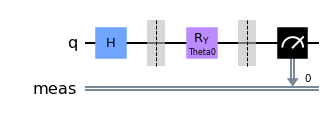

In [9]:
circuit = QuantumCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
print(f'Expected value for rotation [pi/4]: {circuit.run(torch.Tensor([np.pi/4] * len(QC_OUTPUTS)))}')
circuit.circuit.draw(output='mpl')

In [50]:
class TorchCircuit(Function):
    @staticmethod
    def forward(ctx, input):
        if not hasattr(ctx, 'QuantumCircuit'):
            ctx.QuantumCircuit = QuantumCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
        
        exp_value = ctx.QuantumCircuit.run(input)    
        
        result = torch.Tensor([exp_value])
        
        ctx.save_for_backward(result, input)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        forward_tensor,i = ctx.saved_tensors
        
        input_numbers = i
        gradients = torch.Tensor()
        
        for k in range(NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT
            
            expectation_right = ctx.QuantumCircuit.run(shift_right)
            expectation_left = ctx.QuantumCircuit.run(shift_left)
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradient = gradient / torch.norm(gradient)
            
            gradients = torch.cat((gradients, gradient.float()))
            
        result = torch.Tensor(gradients)
        
        return (result.float() * grad_output.float()).T

In [51]:
class HybridLayer(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self):
        super(HybridLayer, self).__init__()
        
    def forward(self, input):
        return TorchCircuit.apply(input)

In [36]:
x = torch.tensor([np.pi/4] * NUM_QUBITS, requires_grad=True)
qc = TorchCircuit.apply

y1 = qc(x)
print(f'y1 after quantum layer: {y1}')
y1 = nn.Linear(2**NUM_QUBITS, 1)(y1.float())

y1.backward()
print(f'x.grad = {x.grad}')

inside circuit
tensor([0.7854], requires_grad=True)
y1 after quantum layer: tensor([[0.1482, 0.8518]], grad_fn=<TorchCircuitBackward>)
x.grad = tensor([-0.3153])


  3%|▎         | 3/100 [00:00<00:03, 24.50it/s]

inside circuit
tensor([-0.7854], requires_grad=True)
inside circuit
tensor([-0.8854], requires_grad=True)
inside circuit
tensor([-0.9854], requires_grad=True)
inside circuit
tensor([-1.0853], requires_grad=True)
inside circuit
tensor([-1.1851], requires_grad=True)
inside circuit
tensor([-1.2850], requires_grad=True)


  9%|▉         | 9/100 [00:00<00:03, 26.26it/s]

inside circuit
tensor([-1.3847], requires_grad=True)
inside circuit
tensor([-1.4844], requires_grad=True)
inside circuit
tensor([-1.5840], requires_grad=True)
inside circuit
tensor([-1.6515], requires_grad=True)
inside circuit
tensor([-1.6936], requires_grad=True)
inside circuit
tensor([-1.7153], requires_grad=True)


 15%|█▌        | 15/100 [00:00<00:03, 25.17it/s]

inside circuit
tensor([-1.7202], requires_grad=True)
inside circuit
tensor([-1.7112], requires_grad=True)
inside circuit
tensor([-1.6905], requires_grad=True)
inside circuit
tensor([-1.6600], requires_grad=True)
inside circuit
tensor([-1.6210], requires_grad=True)


 21%|██        | 21/100 [00:00<00:03, 25.97it/s]

inside circuit
tensor([-1.5748], requires_grad=True)
inside circuit
tensor([-1.5224], requires_grad=True)
inside circuit
tensor([-1.4875], requires_grad=True)
inside circuit
tensor([-1.4678], requires_grad=True)
inside circuit
tensor([-1.4614], requires_grad=True)
inside circuit
tensor([-1.4668], requires_grad=True)


 27%|██▋       | 27/100 [00:01<00:02, 24.73it/s]

inside circuit
tensor([-1.4825], requires_grad=True)
inside circuit
tensor([-1.5073], requires_grad=True)
inside circuit
tensor([-1.5401], requires_grad=True)
inside circuit
tensor([-1.5801], requires_grad=True)
inside circuit
tensor([-1.6263], requires_grad=True)


 33%|███▎      | 33/100 [00:01<00:02, 25.07it/s]

inside circuit
tensor([-1.6572], requires_grad=True)
inside circuit
tensor([-1.6745], requires_grad=True)
inside circuit
tensor([-1.6795], requires_grad=True)
inside circuit
tensor([-1.6737], requires_grad=True)
inside circuit
tensor([-1.6582], requires_grad=True)
inside circuit
tensor([-1.6340], requires_grad=True)


 39%|███▉      | 39/100 [00:01<00:02, 25.99it/s]

inside circuit
tensor([-1.6020], requires_grad=True)
inside circuit
tensor([-1.5631], requires_grad=True)
inside circuit
tensor([-1.5384], requires_grad=True)
inside circuit
tensor([-1.5263], requires_grad=True)
inside circuit
tensor([-1.5257], requires_grad=True)
inside circuit
tensor([-1.5352], requires_grad=True)


 45%|████▌     | 45/100 [00:01<00:02, 26.78it/s]

inside circuit
tensor([-1.5538], requires_grad=True)
inside circuit
tensor([-1.5807], requires_grad=True)
inside circuit
tensor([-1.5947], requires_grad=True)
inside circuit
tensor([-1.5973], requires_grad=True)
inside circuit
tensor([-1.5895], requires_grad=True)
inside circuit
tensor([-1.5725], requires_grad=True)


 51%|█████     | 51/100 [00:01<00:01, 27.03it/s]

inside circuit
tensor([-1.5472], requires_grad=True)
inside circuit
tensor([-1.5344], requires_grad=True)
inside circuit
tensor([-1.5330], requires_grad=True)
inside circuit
tensor([-1.5417], requires_grad=True)
inside circuit
tensor([-1.5596], requires_grad=True)
inside circuit
tensor([-1.5857], requires_grad=True)


 57%|█████▋    | 57/100 [00:02<00:01, 27.12it/s]

inside circuit
tensor([-1.5991], requires_grad=True)
inside circuit
tensor([-1.6012], requires_grad=True)
inside circuit
tensor([-1.5931], requires_grad=True)
inside circuit
tensor([-1.5758], requires_grad=True)
inside circuit
tensor([-1.5503], requires_grad=True)
inside circuit
tensor([-1.5373], requires_grad=True)


 63%|██████▎   | 63/100 [00:02<00:01, 27.03it/s]

inside circuit
tensor([-1.5356], requires_grad=True)
inside circuit
tensor([-1.5440], requires_grad=True)
inside circuit
tensor([-1.5616], requires_grad=True)
inside circuit
tensor([-1.5675], requires_grad=True)
inside circuit
tensor([-1.5827], requires_grad=True)
inside circuit
tensor([-1.5865], requires_grad=True)


 69%|██████▉   | 69/100 [00:02<00:01, 27.22it/s]

inside circuit
tensor([-1.5798], requires_grad=True)
inside circuit
tensor([-1.5639], requires_grad=True)
inside circuit
tensor([-1.5595], requires_grad=True)
inside circuit
tensor([-1.5656], requires_grad=True)
inside circuit
tensor([-1.5810], requires_grad=True)
inside circuit
tensor([-1.5849], requires_grad=True)


 75%|███████▌  | 75/100 [00:02<00:00, 27.56it/s]

inside circuit
tensor([-1.5785], requires_grad=True)
inside circuit
tensor([-1.5627], requires_grad=True)
inside circuit
tensor([-1.5584], requires_grad=True)
inside circuit
tensor([-1.5646], requires_grad=True)
inside circuit
tensor([-1.5801], requires_grad=True)
inside circuit
tensor([-1.5841], requires_grad=True)


 81%|████████  | 81/100 [00:03<00:00, 27.30it/s]

inside circuit
tensor([-1.5777], requires_grad=True)
inside circuit
tensor([-1.5620], requires_grad=True)
inside circuit
tensor([nan], requires_grad=True)
inside circuit
tensor([nan], requires_grad=True)
inside circuit
tensor([nan], requires_grad=True)
inside circuit
tensor([nan], requires_grad=True)


 87%|████████▋ | 87/100 [00:03<00:00, 27.64it/s]

inside circuit
tensor([nan], requires_grad=True)
inside circuit
tensor([nan], requires_grad=True)
inside circuit
tensor([nan], requires_grad=True)
inside circuit
tensor([nan], requires_grad=True)
inside circuit
tensor([nan], requires_grad=True)
inside circuit
tensor([nan], requires_grad=True)


 93%|█████████▎| 93/100 [00:03<00:00, 27.32it/s]

inside circuit
tensor([nan], requires_grad=True)
inside circuit
tensor([nan], requires_grad=True)
inside circuit
tensor([nan], requires_grad=True)
inside circuit
tensor([nan], requires_grad=True)
inside circuit
tensor([nan], requires_grad=True)
inside circuit
tensor([nan], requires_grad=True)


 99%|█████████▉| 99/100 [00:03<00:00, 27.50it/s]

inside circuit
tensor([nan], requires_grad=True)
inside circuit
tensor([nan], requires_grad=True)
inside circuit
tensor([nan], requires_grad=True)
inside circuit
tensor([nan], requires_grad=True)
inside circuit
tensor([nan], requires_grad=True)
inside circuit
tensor([nan], requires_grad=True)


100%|██████████| 100/100 [00:03<00:00, 26.60it/s]


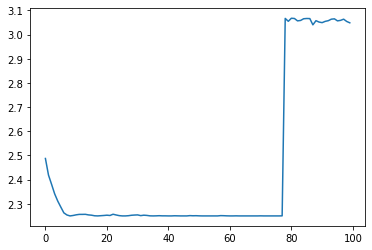

In [37]:
qc = TorchCircuit.apply

def cost(x):
    target = -1
    expval = qc(x)[0]
    
    val = sum([(i + 1) * expval[i] for i in range(2**NUM_QUBITS)]) / 2**NUM_QUBITS
    
    return torch.abs(target - val) ** 2, expval


x = torch.tensor([-np.pi/4] * NUM_QUBITS, requires_grad=True)
opt = optim.Adam([x], lr = 0.1)

num_epoch = 100

loss_list = []
expval_list = []

for i in tqdm(range(num_epoch)):
    opt.zero_grad()
    loss, expval = cost(x)
    loss.backward()
    
    opt.step()
    loss_list.append(loss.item())
    expval_list.append(expval)
    
plt.plot(loss_list)

In [38]:
from torch.functional import F

In [39]:
import numpy as np
import torchvision
from torchvision import datasets, transforms

In [40]:
TRAIN_DATA_PATH = "./data/hurricane_damage_dataset/test/"
TEST_DATA_PATH = "./data/hurricane_damage_dataset/validation_another/"

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])


train_samples = 900
test_samples = 100


train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
# train_idx = np.append(np.where(train_data.targets == 0)[0][:train_samples], 
#                 np.where(train_data.targets == 1)[0][:train_samples])

X_train = torch.utils.data.Subset(train_data, np.random.choice(len(train_data), train_samples, replace=False))


# train_data.data = train_data.data[train_idx]
# train_data.targets = train_data.targets[train_idx]

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
# test_idx = np.append(np.where(test_data.targets == 0)[0][:test_samples], 
#                 np.where(test_data.targets == 1)[0][:test_samples])

# test_data.data = test_data.data[test_idx]
# test_data.targets = test_data.targets[test_idx]

X_test = torch.utils.data.Subset(test_data, np.random.choice(len(test_data), test_samples, replace=False))


train_loader = torch.utils.data.DataLoader(X_train, batch_size=100, shuffle=True, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(X_test, batch_size=100, shuffle=True) 

In [41]:
# tforms = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor(),
#                              transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
# train_tfroms = transforms.Compose([transforms.Resize((128, 128)),transforms.ColorJitter(),
#                                    transforms.RandomHorizontalFlip(), transforms.ToTensor(),
#                                    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

# # Load train image data
# traindataFromFolders = datasets.ImageFolder(root = './data/hurricane_damage_dataset/train_another/', transform = train_tfroms)
# train_loader = DataLoader(traindataFromFolders, batch_size = 100,  shuffle = True)
# x_train, y_train = iter(train_loader).next()

# # Load validation image data
# valdataFromFolders = datasets.ImageFolder(root = './data/hurricane_damage_dataset/validation_another/', transform = tforms)
# val_loader = DataLoader(valdataFromFolders,batch_size = 100, shuffle = True)
# x_val, y_val = iter(val_loader).next()

# # Load test image data
# testdataFromFolders = datasets.ImageFolder(root = './data/hurricane_damage_dataset/test_another/', transform = train_tfroms)
# test_loader = DataLoader(testdataFromFolders,batch_size = 20, shuffle = False)
# x_test, y_test = iter(test_loader).next()


In [42]:
# n_sample_shape = (8, 6)
# count = 0
# fig, axes = plt.subplots(nrows=n_sample_shape[0], ncols=n_sample_shape[1], figsize=(10, 2*n_sample_shape[0]))

# # classes_map = {
# #     0: 'T-shirt/top',
# #     1: 'Trouser',
# #     2: 'Pullover',
# #     3: 'Dress',
# #     4: 'Coat',
# #     5: 'Sandal',
# #     6: 'Shirt',
# #     7: 'Sneaker',
# #     8: 'Bag',
# #     9: 'Ankle boot'
# # }

# # network.eval()
# # with torch.no_grad():
# for batch_idx, (data, target) in enumerate(test_loader):
#     if count == n_sample_shape[0]*n_sample_shape[1]:
#         break

# #     prediction = network.predict(data).item()

#     prepared_img = data[0].numpy().squeeze()

#     axes[count // n_sample_shape[1]][count % n_sample_shape[1]].imshow(data[0].permute(1, 2, 0))

#     axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_xticks([])
#     axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_yticks([])
#     axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_title(target[0].item())

#     count += 1

In [43]:

# n_samples = 1000

# X_train = datasets.FashionMNIST(root='./data', 
#                                 train=True,
#                                 download=True,
#                                 transform=transforms.Compose([transforms.ToTensor()]))

# idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
#                 np.where(X_train.targets == 1)[0][:n_samples])
# # idx = np.append(idx, 
# #                 np.where(X_train.targets == 2)[0][:n_samples])
# # idx = np.append(idx, 
# #                 np.where(X_train.targets == 3)[0][:n_samples])

# X_train.data = X_train.data[idx]
# X_train.targets = X_train.targets[idx]

In [44]:
# train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True, pin_memory=True)

In [45]:
# n_samples = 50

# X_test = datasets.FashionMNIST(root='./data', 
#                                train=False,
#                                download=True,
#                                transform=transforms.Compose([transforms.ToTensor()]))

# idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
#                 np.where(X_test.targets == 1)[0][:n_samples])
# # idx = np.append(idx, 
# #                 np.where(X_test.targets == 2)[0][:n_samples])
# # idx = np.append(idx, 
# #                 np.where(X_test.targets == 3)[0][:n_samples])

# X_test.data = X_test.data[idx]
# X_test.targets = X_test.targets[idx]

In [46]:
# test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

# Building network

In [55]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv3 = nn.Conv2d(20, 20, kernel_size=5)
#         self.conv4 = nn.Conv2d(20, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, NUM_QUBITS)
#         self.qc = TorchCircuit.apply
#         self.qcsim = nn.Linear(NUM_QUBITS, 1)

        DROPOUT = 0.5
    
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, stride = 1, padding = 1)
        self.convnorm1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=6, stride=1, padding=1)
        self.convnorm2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d((2, 2))

        self.conv3 = nn.Conv2d(64, 64, kernel_size = 6, stride = 1, padding = 1)
        self.convnorm3 = nn.BatchNorm2d(64)
        self.pool3 = nn.AvgPool2d((2, 2))

        self.dropout = nn.Dropout(DROPOUT)
        self.linear1 = nn.Linear(64 * 13 * 13, 16)
        self.linear1_bn = nn.BatchNorm1d(16)
        self.linear2 = nn.Linear(16, NUM_QUBITS)
        self.linear2_bn = nn.BatchNorm1d(NUM_QUBITS)
#         self.linear2 = nn.Linear(16, 2)
#         self.linear2_bn = nn.BatchNorm1d(2)
#         self.qc = TorchCircuit.apply
        self.qc = HybridLayer()
        self.sigmoid = torch.sigmoid
        self.relu = torch.relu

        
        
    def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2(x), 2))
#         x = F.relu(F.max_pool2d(self.conv3(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv4(x)), 2))
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         x = np.pi*torch.tanh(x)
        
#         MODE = 'QC'
        
#         if MODE == 'QC':
#             x = self.qc(x[0])
#         else:
#             x = self.qcsim(x)
            
#         x = torch.sigmoid(x)
#         x = torch.cat((x, 1-x), -1)
        
#         return x




#         x = self.pool1(self.relu(self.conv1(x)))
#         x = self.pool2(self.relu(self.conv2(x)))
#         x = self.pool3(self.relu(self.conv3(x)))
#         x = x.view(-1, 64 * 13 * 13)
#         x = self.dropout(self.relu(self.linear1(x)))
#         x = self.dropout(self.relu(self.linear2(x)))


        x = self.pool1(self.convnorm1(self.relu(self.conv1(x))))
        x = self.pool2(self.convnorm2(self.relu(self.conv2(x))))
        x = self.pool3(self.convnorm3(self.relu(self.conv3(x))))
        x = x.view(-1, 64 * 13 * 13)
        x = self.dropout(self.linear1_bn(self.relu(self.linear1(x))))
        x = self.dropout(self.linear2_bn(self.relu(self.linear2(x))))
        
#         print(x)

        x = torch.cat((x, torch.zeros(25, 1)), dim=-1)
#         x.apply_(lambda x: x + 1)
#         print(x)
    
        y = torch.zeros_like(x, device=x.device)
        
        for i in range(0, BATCH_SIZE):
            qc_res = self.qc(x[i])
#             print(qc_res)
#             cat_res = torch.cat((qc_res, 1-qc_res), -1)
#             print(cat_res)
#             arg_max_res = torch.argmax(cat_res[0])
#             print(arg_max_res)
#             print(torch.argmax(qc_res[0]).item())

#             x[i] = torch.cat((qc_res, 1-qc_res), -1) # TODO: maybe more correct ????
#             x[i] = torch.argmax(qc_res[0]) # TODO: maybe more correct ????

            y[i] = qc_res[0]
            
#         x = self.qc(x[0])
        x = y

        x = self.sigmoid(x)
        
#         x = torch.cat((x, 1-x), -1)
        
        return x
    
    
    def predict(self, x):
        
#         return self.forward(x)
        pred = self.forward(x)
        ans = torch.argmax(pred[0]).item()
        
        return torch.tensor(ans)
    
# network = Net()
# optimizer = optim.Adam(network.parameters(), lr=0.001)

LR = 0.01

network = Net()
# optimizer = torch.optim.SGD(network.parameters(), lr = LR, momentum = 0.9)



In [56]:
import os

# Pytoch
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn

# Data science tools
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Timing utility
from timeit import default_timer as timer

# Visualizationsos
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.pyplot as plt

import os


def acc(x, y, model, return_labels = False):
    with torch.no_grad():
        logits = model(x)
        pred_labels = np.argmax(logits.cpu().numpy(), axis = 1)
    if return_labels:
        return pred_labels
    else:
        return 100*accuracy_score(y.cpu().numpy(), pred_labels)


def train_network(network, optimizer, train_loader, val_loader):
    epochs = 20
    criterion = nn.CrossEntropyLoss()

    loaders = {
        'train': train_loader,
        'val': val_loader
    }
    
    loss_results = {
        'train': [],
        'val': []
    }

    acc_results = {
        'train': [],
        'val': []
    }

    loaders = {
        'train': train_loader,
        'val': test_loader
    }

    x_train, y_train = iter(train_loader).next()
    x_val, y_val = iter(val_loader).next()
        
    history_li = []

    for epoch in range(epochs):
        total_loss = {
            'train': [],
            'val': []
        }

        total_acc = {
            'train': [],
            'val': []
        }
        
        train_loss = 0.0
        val_loss = 0.0

        train_acc = 0
        val_acc = 0

        # Set to training
        network.train()
        start = timer()

        loss_train = 0
        network.train()
        
        for batch in range(len(x_train)//BATCH_SIZE):

            inds = slice(batch*BATCH_SIZE, (batch+1)*BATCH_SIZE)
            optimizer.zero_grad()
            logits = network(x_train[inds])
            print(logits)
            print(y_train[inds])
            loss = criterion(logits, y_train[inds])
            print(loss)
            print('back')
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

            # Track train loss
            train_loss += loss.item()
            train_acc = acc(x_train, y_train, network)

        network.eval()

        with torch.no_grad():
            y_val_pred = network(x_val)
            loss = criterion(y_val_pred, y_val)
            val_loss = loss.item()
            val_acc = acc(x_val, y_val, network)
            loss_test = loss.item()

            history_li.append([train_loss/BATCH_SIZE, val_loss, train_acc, val_acc])
            torch.save(network.state_dict(), 'model_custom.pt')
            torch.cuda.empty_cache()
        print("Epoch {} | Train Loss {:.5f}, Train Acc {:.2f} - Test Loss {:.5f}, Test Acc {:.2f}".format(
            epoch, loss_train/BATCH_SIZE, train_acc, val_loss, val_acc))

        history = pd.DataFrame(history_li, columns=['train_loss', 'val_loss', 'train_acc', 'val_acc'])

        loss_results['train'].append(loss_train/BATCH_SIZE)
        loss_results['val'].append(val_loss)
        
        acc_results['train'].append(train_acc)
        acc_results['val'].append(val_acc)

#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 network.train(True)
#             else:
#                 network.train(False)

#             correct = 0
#             number = 0

#             for batch_idx, (data, target) in enumerate(loaders[phase]):
#                 optimizer.zero_grad()
#                 output = network(data)

#                 loss = criterion(output, target)

#                 if phase == 'train':
#                     loss.backward()
#                     optimizer.step()

#                 total_loss[phase].append(loss.item())

#                 _, predicted = torch.max(output.data, 1)
#                 number += target.size(0)
#                 correct += (predicted == target).sum().item()

#             loss_results[phase].append(sum(total_loss[phase]) / len(total_loss[phase]))
#             acc_results[phase].append(100 * correct / number)

#         progress = 100.0 * (epoch + 1) / epochs

#         print(f'Training [{int(progress)}%]\tTraining loss {loss_results["train"][-1]}\tValidation loss {loss_results["val"][-1]}\tTraining acc {acc_results["train"][-1]}\tValidation acc {acc_results["val"][-1]}')
        
    return {
        'train_loss': loss_results["train"][-1],
        'val_loss': loss_results["val"][-1],
        'train_acc': acc_results["train"][-1],
        'val_acc': acc_results["val"][-1]
    }


In [57]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, ConcatDataset

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

dataset = ConcatDataset([X_train, X_test])

k_folds = 5

kfold = KFold(n_splits=k_folds, shuffle=True)

results = {}

print('--------------------------------')

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
  
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=BATCH_SIZE, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=BATCH_SIZE, sampler=test_subsampler)

    network = Net()
    network.apply(reset_weights)
    
#     optimizer = optim.Adam(network.parameters(), lr=0.00002)
    optimizer = torch.optim.SGD(network.parameters(), lr = LR, momentum = 0.9)
    
    result = train_network(network, optimizer, trainloader, testloader)
    
    results[fold] = result
    
    print(result)
    print('--------------------------------')

print('--------------------------------')
print('FINAL RESULTS')
print('--------------------------------')
print(results)
    

--------------------------------
FOLD 0
--------------------------------
inside circuit
tensor([-1.5015,  0.0000], grad_fn=<SelectBackward>)
i[0].tolist()
-1.5015006065368652
inside circuit
tensor([0., 0.], grad_fn=<SelectBackward>)
i[0].tolist()
0.0
inside circuit
tensor([-1.7340,  0.0000], grad_fn=<SelectBackward>)
i[0].tolist()
-1.7340492010116577
inside circuit
tensor([-0., 0.], grad_fn=<SelectBackward>)
i[0].tolist()
-0.0
inside circuit
tensor([-1.7340,  0.0000], grad_fn=<SelectBackward>)
i[0].tolist()
-1.7340492010116577
inside circuit
tensor([-1.7340,  0.0000], grad_fn=<SelectBackward>)
i[0].tolist()
-1.7340492010116577
inside circuit
tensor([-0.6654,  0.0000], grad_fn=<SelectBackward>)
i[0].tolist()
-0.6654409766197205
inside circuit
tensor([0., 0.], grad_fn=<SelectBackward>)
i[0].tolist()
0.0
inside circuit
tensor([-1.7340,  0.0000], grad_fn=<SelectBackward>)
i[0].tolist()
-1.7340492010116577
inside circuit
tensor([-1.7340,  0.0000], grad_fn=<SelectBackward>)
i[0].tolist()
-1.

RuntimeError: Function TorchCircuitBackward returned an invalid gradient at index 0 - got [2, 1] but expected shape compatible with [2]

In [ ]:
# epochs = 25
# loss_func = nn.CrossEntropyLoss()

# loss_results = {
#     'train': [],
#     'val': []
# }

# acc_results = {
#     'train': [],
#     'val': []
# }

# loaders = {
#     'train': train_loader,
#     'val': test_loader
# }

# for epoch in range(epochs):
#     total_loss = {
#         'train': [],
#         'val': []
#     }
    
#     total_acc = {
#         'train': [],
#         'val': []
#     }
    
    
#     for phase in ['train', 'val']:
#         if phase == 'train':
#             network.train(True)
#         else:
#             network.train(False)
        
#         correct = 0
#         number = 0
        
#         for batch_idx, (data, target) in enumerate(loaders[phase]):
#             optimizer.zero_grad()
#             output = network(data)
            
#             loss = loss_func(output, target)
            
#             if phase == 'train':
#                 loss.backward()
#                 optimizer.step()

#             total_loss[phase].append(loss.item())

#             _, predicted = torch.max(output.data, 1)
#             number += target.size(0)
#             correct += (predicted == target).sum().item()

#         loss_results[phase].append(sum(total_loss[phase]) / len(total_loss[phase]))
#         acc_results[phase].append(100 * correct / number)

#     progress = 100.0 * (epoch + 1) / epochs
    
#     print(f'Training [{int(progress)}%]\tTraining loss {loss_results["train"][-1]}\tValidation loss {loss_results["val"][-1]}\tTraining acc {acc_results["train"][-1]}\tValidation acc {acc_results["val"][-1]}')
    

In [ ]:
# plt.plot(loss_results["train"])
# plt.title(f'Hybrid NN training convergence for {NUM_QUBITS}-qubits')
# plt.xlabel('epoch')
# plt.ylabel('loss')

In [ ]:
# plt.plot(loss_results["val"])
# plt.title(f'Hybrid NN training convergence for {NUM_QUBITS}-qubits')
# plt.xlabel('epoch')
# plt.ylabel('loss')

# Test accuracy

In [ ]:
# accuracy = 0
# number = 0
# for batch_idx, (data, target) in enumerate(test_loader):
#     number += 1
#     output = network.predict(data).item()
#     accuracy += (output == target[0].item())*1

In [ ]:
# print(f'Performance on test data: {accuracy}/{number} = {accuracy/number*100}%')

In [ ]:
# n_sample_shape = (8, 6)
# count = 0
# fig, axes = plt.subplots(nrows=n_sample_shape[0], ncols=n_sample_shape[1], figsize=(10, 2*n_sample_shape[0]))

# classes_map = {
#     0: 'T-shirt/top',
#     1: 'Trouser',
#     2: 'Pullover',
#     3: 'Dress',
#     4: 'Coat',
#     5: 'Sandal',
#     6: 'Shirt',
#     7: 'Sneaker',
#     8: 'Bag',
#     9: 'Ankle boot'
# }

# network.eval()
# with torch.no_grad():
#     for batch_idx, (data, target) in enumerate(test_loader):
#         if count == n_sample_shape[0]*n_sample_shape[1]:
#             break
        
#         prediction = network.predict(data).item()
        
#         axes[count // n_sample_shape[1]][count % n_sample_shape[1]].imshow(data[0].numpy().squeeze(), cmap='gray')
        
#         axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_xticks([])
#         axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_yticks([])
#         axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_title(classes_map[prediction])
        
#         count += 1